In [3]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import sys
sys.executable

'/home/vincent/miniconda3/envs/openmmlab/bin/python'

In [5]:
import torch
import torchvision
torch.__version__, torchvision.__version__

('1.6.0', '0.7.0')

In [6]:
from itertools import groupby
import numpy as np
import cv2
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
from multiprocessing import Pool
import matplotlib.pyplot as plt
# import cupy as cp
import ast
from pathlib import Path
import pickle5 as pickle

import shutil
import sys
sys.path.append("../src/")
sys.path.append("../yolov5/")

import util

from joblib import Parallel, delayed

from IPython.display import display, HTML

from matplotlib import animation, rc
rc('animation', html='jshtml')

In [1]:
import albumentations as A

# Images

In [7]:
meta_params = {}
for model_version in ['0120_swin']:#, '0110_yolov5l_fold0_new_hyp_remove_noaug']:
    model_folder = Path(f"../output/{model_version}/")
    try:
        params_path = model_folder / "config" / "params.pkl"
        params = pickle.load(open(params_path, 'rb'))
    except:
        params_path = model_folder / "config" / "params.yaml"
        params = util.load_yaml(params_path)
    meta_params[model_version] = params

In [8]:
for model_version, params in meta_params.items():
    for key, val in params.items():
        if "dir" in key or "path" in key or "file" in key:
            params[key] = Path(val)
    meta_params[model_version] = params

In [9]:
# Train Data
params_eg = list(meta_params.values())[0]
df = pd.read_csv(params_eg['data_path'] / 'train.csv')
df = df.progress_apply(lambda x: util.get_path(x, params_eg, infer=False), axis=1)
df['annotations'] = df['annotations'].progress_apply(lambda x: ast.literal_eval(x))
df["real_bbox"] = df["annotations"].apply(lambda annots: [list(annot.values()) for annot in annots])
display(df.head(2))

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

video_id  sequence  video_frame  sequence_frame image_id annotations  \
0         0     40258            0               0      0-0          []   
1         0     40258            1               1      0-1          []   

                                      old_image_path  \
0  /home/vincent/Kaggle/data/tensorflow-great-bar...   
1  /home/vincent/Kaggle/data/tensorflow-great-bar...   

                                          image_path  \
0  /home/vincent/Kaggle/data/tensorflow-great-bar...   
1  /home/vincent/Kaggle/data/tensorflow-great-bar...   

                                          label_path real_bbox  
0  /home/vincent/Kaggle/data/tensorflow-great-bar...        []  
1  /home/vincent/Kaggle/data/tensorflow-great-bar...        []

In [12]:
df['num_bbox'] = df['annotations'].progress_apply(lambda x: len(x))

  0%|          | 0/23501 [00:00<?, ?it/s]

In [19]:
color_pred = [(0,255,0)]    
color_real = [(255,0,0)]
def plot_img(df, idx):
    row = df.loc[idx]
    path = row["image_path"]
    img = cv2.imread(str(path))[...,::-1]
    real_bboxes = row["real_bbox"]
    display(util.show_img(img, 
                          real_bboxes, 
                          color_real[0], 
                          bbox_format='coco', 
                          labels= [1] * len(real_bboxes))
    )

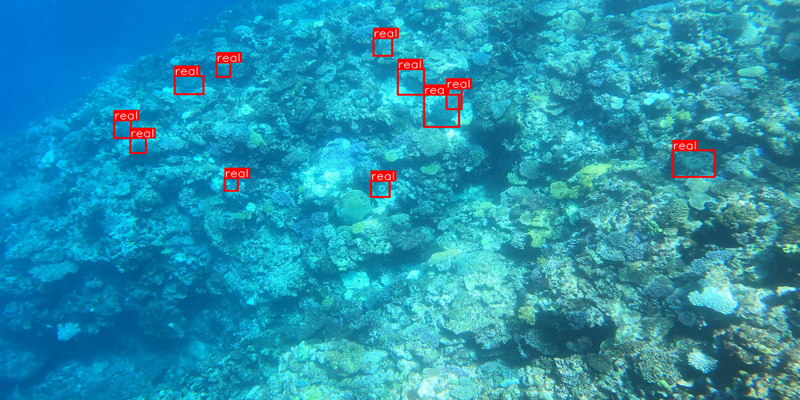

In [20]:
df_p10 = df.query("num_bbox > 10").copy()
df_p10.reset_index(drop=True, inplace=True)
plot_img(df_p10, 1)

# Albumentation

In [29]:
import random
import albumentations as A
def visualize(image):
    plt.figure(figsize=(25.6, 14))
    plt.axis('off')
    plt.imshow(image)

In [67]:
import mmcv
img = mmcv.imread('../mmdetection/tests/data/color.jpg')
res = mmcv.imrescale(img, (1000, 600), return_scale=True)

In [74]:
img.shape

(288, 512, 3)

In [75]:
1000/512, 600 / 288

(1.953125, 2.0833333333333335)

In [71]:
res[0].shape

(600, 1000, 3)

In [60]:
row = df_p10.loc[1]
path = row["image_path"]
img = cv2.imread(str(path))[...,::-1]
img.shape

(720, 1280, 3)

## Original

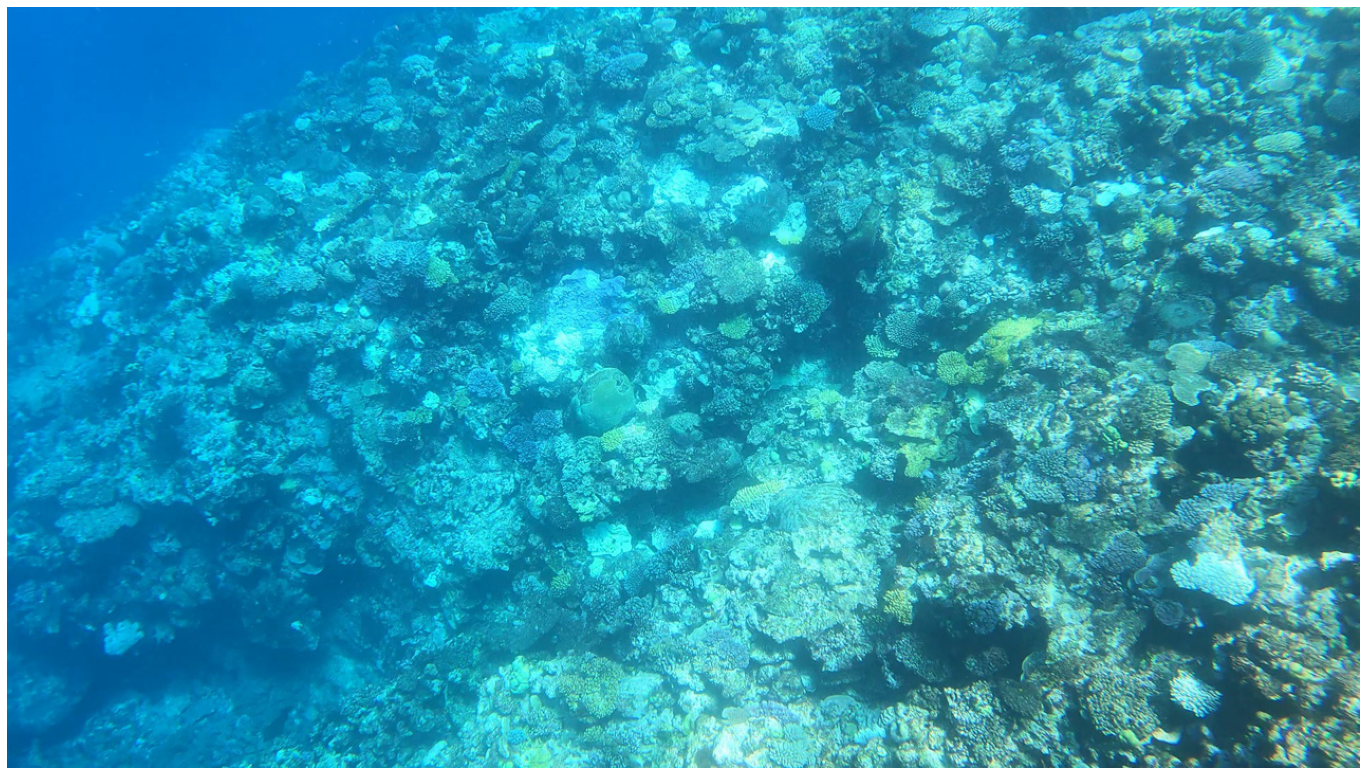

In [37]:
visualize(img)

In [59]:
img.shape

(720, 1280, 3)

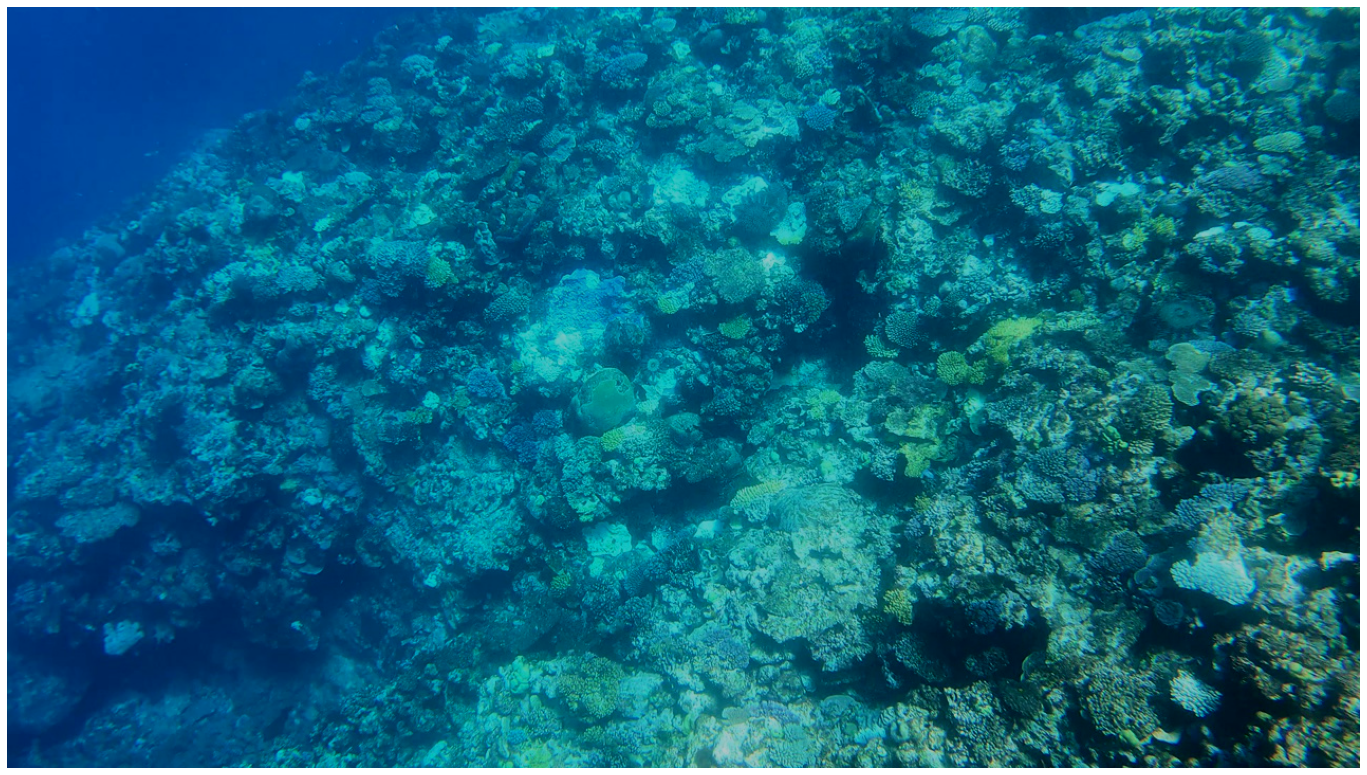

In [56]:
#transform = A.HorizontalFlip(p=0.5)
#transform = A.ShiftScaleRotate(p=1)
transform = A.Compose([
    #A.GridDistortion(p=1,),
    #A.RandomRotate90(p=.5),
    #A.Transpose(p=.5),
    #A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
    #A.OpticalDistortion(),
    #A.GridDistortion(),
    A.RandomBrightnessContrast(p=1),
    #A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=1),
])
augmented_image = transform(image=img)['image']
visualize(augmented_image)

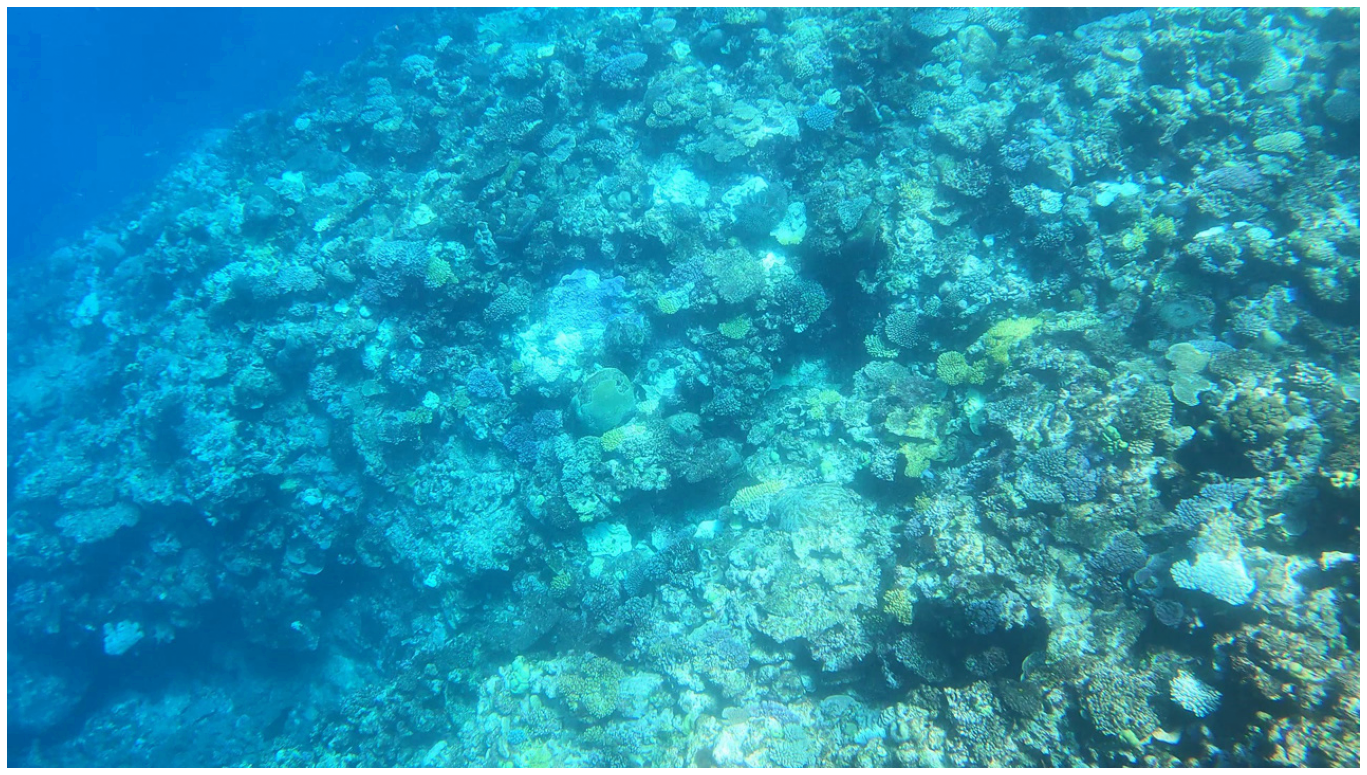

In [49]:
visualize(augmented_image/255)